In [1]:

import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import folium
from folium.plugins import HeatMap
from folium import IFrame
from mpl_toolkits.basemap import Basemap
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from branca.colormap import LinearColormap
import scienceplots as sp

plt.style.use('science')

In [2]:
us_airport_loc = pd.read_csv('./us_airport_loc.csv')
print(us_airport_loc.info())

lat_mean = us_airport_loc['LATITUDE'].mean()
lon_mean = us_airport_loc['LONGITUDE'].mean()
lat_max = us_airport_loc['LATITUDE'].max()
lat_min = us_airport_loc['LATITUDE'].min()
lon_max = us_airport_loc['LONGITUDE'].max()
lon_min = us_airport_loc['LONGITUDE'].min()

shp_file_path = 'States_shapefile-shp/States_shapefile.shp'


def get_airport_location(airport_code):
    airport = us_airport_loc[us_airport_loc['Name'] == airport_code]
    if airport.empty:
        print(f"No location data found for airport {airport_code}")
        return None
    else:
        lat = airport['LATITUDE'].values[0]
        lon = airport['LONGITUDE'].values[0]
        return lat, lon

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70 entries, 0 to 69
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Name       70 non-null     object 
 1   AIRPORT    70 non-null     object 
 2   CITY       70 non-null     object 
 3   STATE      70 non-null     object 
 4   COUNTRY    70 non-null     object 
 5   LATITUDE   70 non-null     float64
 6   LONGITUDE  70 non-null     float64
dtypes: float64(2), object(5)
memory usage: 4.0+ KB
None


In [3]:
weather = np.load('udata/weather2016_2021.npy').T
print(weather.shape)

(78912, 70)


In [4]:
u_mx = np.load('./udata/udelay.npy')
print(u_mx.shape)

arr = u_mx[:, :, 0].T
dep = u_mx[:, :, 1].T

df_arr = pd.DataFrame(arr, index=range(
    78912), columns=us_airport_loc['Name'].tolist())
df_dep = pd.DataFrame(dep, index=range(
    78912), columns=us_airport_loc['Name'].tolist())
df_weather = pd.DataFrame(weather, index=range(78912), columns=us_airport_loc['Name'].tolist())

print(df_weather.shape)


(70, 78912, 2)
(78912, 70)


In [5]:
from datetime import datetime, timedelta


def slot_to_time(slot):
    # Calculate the number of days and the slot within that day.
    days_passed = slot // 36
    slot_in_day = slot % 36

    # Calculate the hour and minute based on the slot_in_day.
    hour = 6 + slot_in_day // 2
    minute = (slot_in_day % 2) * 30

    # Add the days_passed to the starting date (2016-01-01).
    date = datetime(2016, 1, 1) + timedelta(days=days_passed)
    date_str = date.strftime('%Y-%m-%d')

    return f"{date_str} {hour:02d}:{minute:02d}"

In [6]:
from scipy.interpolate import make_interp_spline


def get_delay_time(time_slot, airport_code):
    arr_delay = df_arr.loc[time_slot, :].fillna(0)
    dep_delay = df_dep.loc[time_slot, :].fillna(0)
    weather = df_weather.loc[time_slot, :].fillna(0)

    arr = arr_delay[airport_code]
    dep = dep_delay[airport_code]
    weather_data = weather[airport_code]
    if weather_data > 0:
        weather_data = 1
    else:
        weather_data = 0

    return arr, dep, weather_data


def plot_data(airport_code, time_range, delay_type):
    fig, ax1 = plt.subplots(figsize=(20, 6))

    delay_data = [get_delay_time(i, airport_code) for i in time_range]
    if delay_type == 0:
        label = 'Arrival Delay (min)'
    elif delay_type == 1:
        label = 'Departure Delay (min)'
    ax1.bar(time_range, [d[delay_type]
                          for d in delay_data], label=label, color='blue')
    ax1.set_xlabel('Time Slot')
    ax1.set_ylabel(label, color='blue')
    ax1.tick_params('y', colors='blue')
    # ax1.set_ylim(ymin=0)

    plt.title(f'Delay Data for Airport {airport_code}')
    plt.legend()
    plt.show()


def plot_data_smooth(airport_code, time_range, delay_type):
    fig, ax1 = plt.subplots(figsize=(20, 6))

    delay_data = [get_delay_time(i, airport_code) for i in time_range]
    weather_data = [d[2] for d in delay_data]
    delay_data = [d[delay_type] for d in delay_data]

    if delay_type == 0:
        label = 'Arrival Delay (min)'
    elif delay_type == 1:
        label = 'Departure Delay (min)'

    x_new = np.linspace(min(time_range), max(time_range), 300)
    spl = make_interp_spline(
        time_range, delay_data, k=1)
    y_smooth = spl(x_new)

    ax1.plot(x_new, y_smooth, label=label, color='blue')  # 使用平滑曲线
    ax1.set_xlabel('Time Slot')
    ax1.set_ylabel(label, color='black')
    ax1.tick_params('y', colors='black')
    # ax1.set_ylim(ymin=0)

    ax2 = ax1.twinx()
    ax2.bar(time_range, weather_data,
            color='red', alpha=0.3, label='Abnormal Weather', width=1)
    plt.title(f'Delay and Weather Data for Airport {airport_code}')
    plt.legend()
    plt.show()


start = 200
delta = 36*5
time_range = range(start, start+delta)
# plot_data(airport, time range, arr/dep)
# plot_data_smooth('JFK', time_range, 1)
# plot_data_smooth('SFO', range(0,78912), 1)

# plot_data('BOS',range(0,78912), 1)


In [7]:
def get_weekly_average_delay(airport, delay_type):
    data = []

    for i in range(0, 36 * 7):
        slot = []
        for time in range(i, 78912, 36 * 7):
            arr_time, dep_time, weather_time = get_delay_time(time, airport)
            if delay_type == 'arr':
                slot.append(arr_time)
            elif delay_type == 'dep':
                slot.append(dep_time)
        # 检查slot是否包含无穷大或NaN的值
        if np.all(np.isfinite(slot)):
            mean_value = np.mean(slot)
            if not np.isnan(mean_value):
                data.append(mean_value)

    return data

import pandas as pd

JFK_data = get_weekly_average_delay('JFK', 'dep')
JFK_data_1 = get_weekly_average_delay('JFK', 'arr')

df = pd.DataFrame({'dep_delay': JFK_data, 'arr_delay': JFK_data_1})
df.to_csv('JFK_delay_data.csv', index=False)


In [8]:
SFO_data = get_weekly_average_delay('SFO', 'dep')
SFO_data_1 = get_weekly_average_delay('SFO', 'arr')

df = pd.DataFrame({'dep_delay': SFO_data, 'arr_delay': SFO_data_1})
df.to_csv('SFO_delay_data.csv', index=False)

In [9]:
BOS_data = get_weekly_average_delay('BOS', 'dep')
BOS_data_1 = get_weekly_average_delay('BOS', 'arr')

df = pd.DataFrame({'dep_delay': BOS_data, 'arr_delay': BOS_data_1})
df.to_csv('BOS_delay_data.csv', index=False)

In [10]:
JFKdata_arr = []
JFKdata_dep = []
for i in range(78912):
    JFKdata_arr.append(get_delay_time(i, 'JFK')[0])
    JFKdata_dep.append(get_delay_time(i, 'JFK')[1])

# save to cvs
print(len(JFKdata_arr))
print(len(JFKdata_dep))
df = pd.DataFrame({'arr': JFKdata_arr, 'dep':JFKdata_dep})
df.to_csv('JFK.csv', index=False)

78912
78912


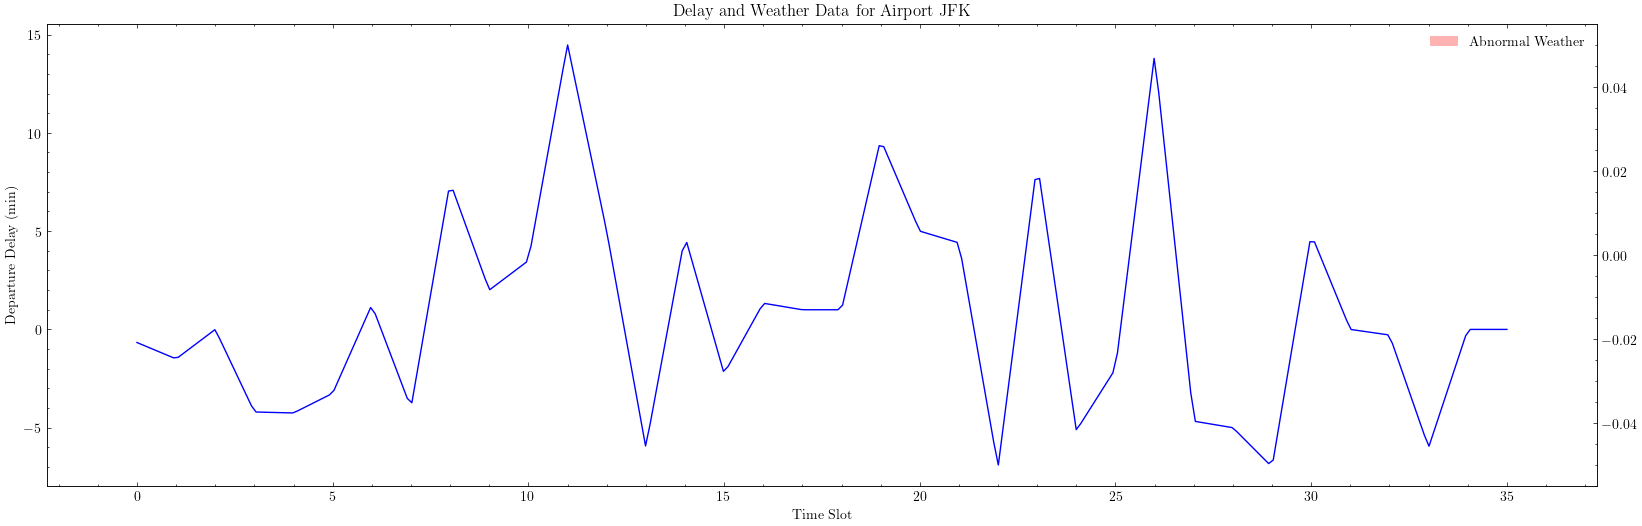

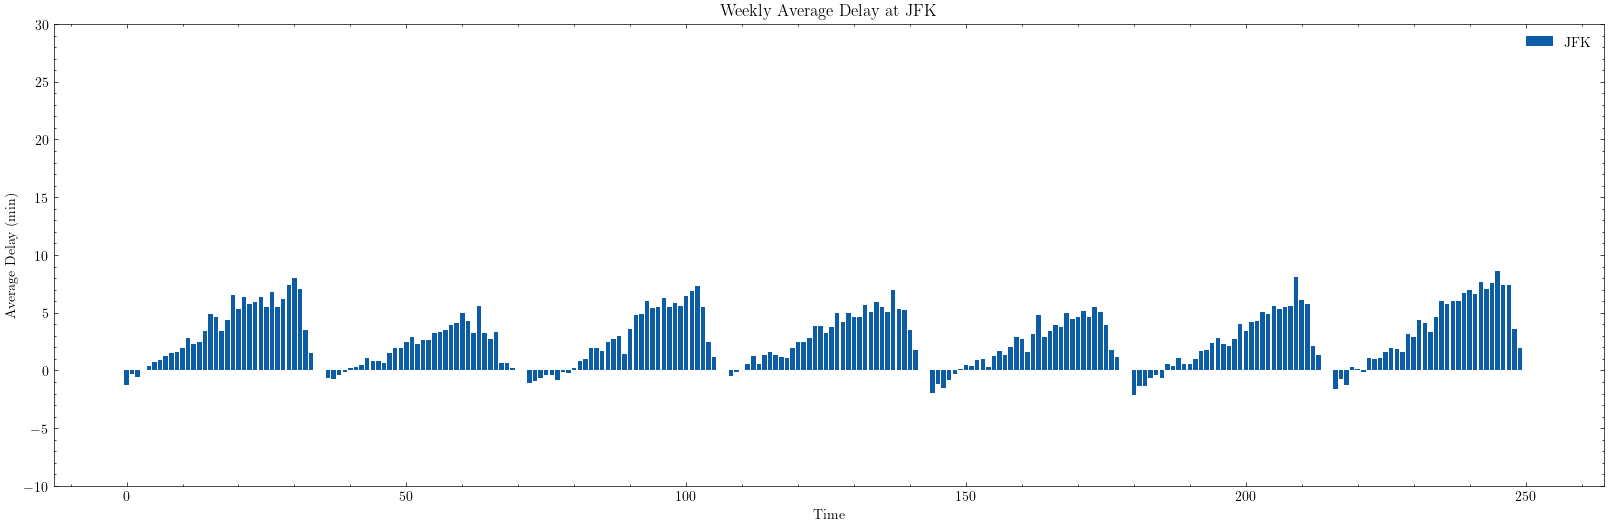

In [11]:
start = 0
delta = 36
time_range = range(start, start+delta)
# plot_data(airport, time range, arr/dep)
plot_data_smooth('JFK', time_range, 1)

data = JFK_data
airport = 'JFK'
fig, ax = plt.subplots(figsize = (20,6))
time_points = list(range(len(data)))
# plt.plot(time_points, data, label=airport)
plt.bar(time_points, data, label=airport)
plt.xlabel('Time')
# plt.xlim(0, 36)
plt.ylim(-10,30)
plt.ylabel('Average Delay (min)')
plt.title(f'Weekly Average Delay at {airport}')
plt.legend()
plt.show()

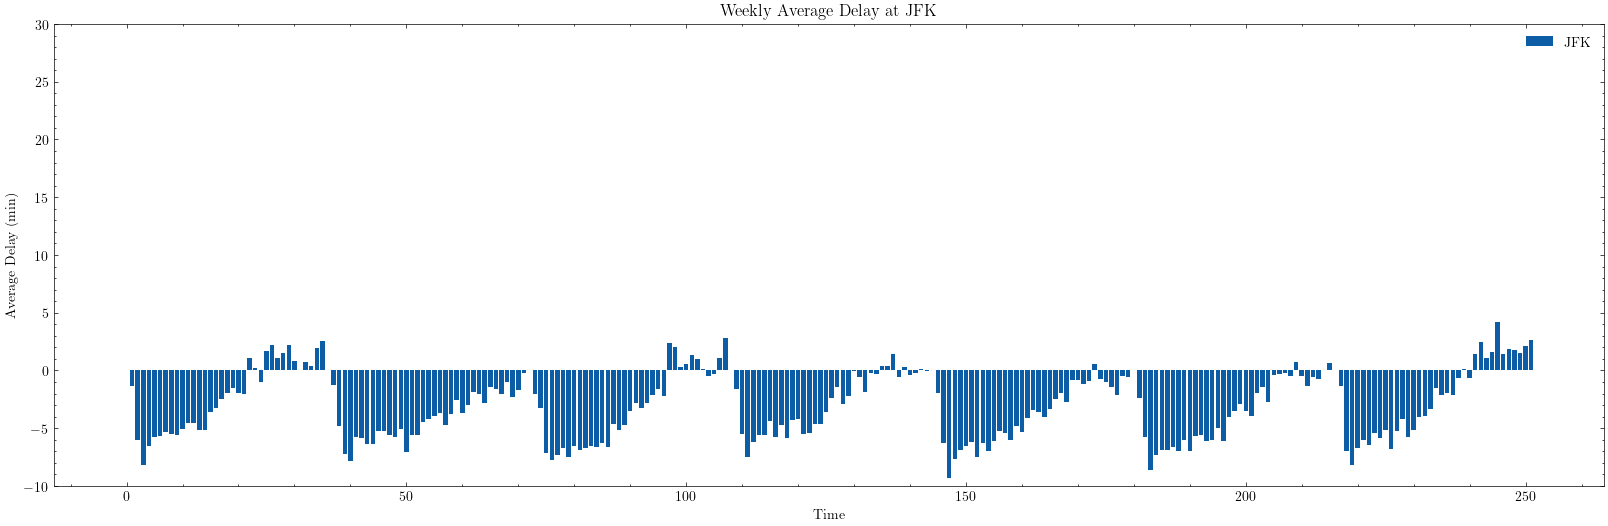

In [12]:
data = JFK_data_1
airport = 'JFK'
fig, ax = plt.subplots(figsize = (20,6))
time_points = list(range(len(data)))
# plt.plot(time_points, data, label=airport)
plt.bar(time_points, data, label=airport)
plt.xlabel('Time')
# plt.xlim(0, 36)
plt.ylim(-10,30)
plt.ylabel('Average Delay (min)')
plt.title(f'Weekly Average Delay at {airport}')
plt.legend()
plt.show()

In [13]:
def plot_map(ax, time_slot, delay_type='dep'):
    map = Basemap(width=11000000, height=5500000,
                  rsphere=(6378137.00, 6356752.3142),
                  resolution='l', area_thresh=1000., projection='lcc',
                  lat_1=45., lat_2=55, lat_0=45, lon_0=-110., ax=ax)
    map.drawcoastlines(linewidth=0.5)
    map.drawstates(linewidth=0.5)
    map.drawcountries(linewidth=1.5)
    map.fillcontinents(color='lightgray')
    # map.fillcontinents(color='lightgray', lake_color='lightblue')
    # map.drawmapboundary(fill_color='lightblue')
    plot_airports(ax, map, s=40, time_slot=time_slot, delay_type=delay_type)
    return map


def plot_airports(ax, map, s, time_slot, delay_type, dep=None, arr=None):
    time_slot = time_slot

    arr_delay = df_arr.loc[time_slot, :].fillna(0)
    dep_delay = df_dep.loc[time_slot, :].fillna(0)

    cmap = plt.get_cmap('jet')
    norm = plt.Normalize(-10, 30)

    for airport in us_airport_loc['Name']:
        lat, lon = get_airport_location(airport)
        x, y = map(lon, lat)
        arr = arr_delay[airport]
        dep = dep_delay[airport]

        if delay_type == 'arr':
            size = s * norm(arr)
            color = cmap(norm(arr))
            data = arr
        elif delay_type == 'dep':
            size = s * norm(dep)
            color = cmap(norm(dep))
            data = dep

        size = max(0, size)
        res = []
        if data > 10:
            res.append([airport, data])
            # ax.text(x, y, airport, fontsize=15, color='black', ha='center', va='center')

        map.scatter(x, y, s=size*size+100, color=color, marker='o', alpha=0.8)

        for i in res:
            print("Time Slot: %d, Airport: %s, Delay: %f, Type: %s" % (time_slot, airport, data, delay_type))




Time Slot: 0, Airport: ABQ, Delay: 12.333333, Type: dep
Time Slot: 0, Airport: HNL, Delay: 19.666667, Type: dep
Time Slot: 0, Airport: OAK, Delay: 18.000000, Type: dep
Time Slot: 0, Airport: OKC, Delay: 30.000000, Type: dep
Time Slot: 0, Airport: OMA, Delay: 12.000000, Type: dep
Time Slot: 0, Airport: ONT, Delay: 11.000000, Type: dep
Time Slot: 0, Airport: PIT, Delay: 22.000000, Type: dep
Time Slot: 2, Airport: DCA, Delay: 15.333333, Type: dep
Time Slot: 2, Airport: TPA, Delay: 12.000000, Type: dep
Time Slot: 5, Airport: BWI, Delay: 10.307692, Type: dep
Time Slot: 5, Airport: DAL, Delay: 14.000000, Type: dep
Time Slot: 5, Airport: HOU, Delay: 10.333333, Type: dep
Time Slot: 5, Airport: TUL, Delay: 10.500000, Type: dep
Time Slot: 11, Airport: IND, Delay: 10.200000, Type: dep
Time Slot: 11, Airport: JFK, Delay: 14.500000, Type: dep
Time Slot: 11, Airport: MCI, Delay: 13.250000, Type: dep


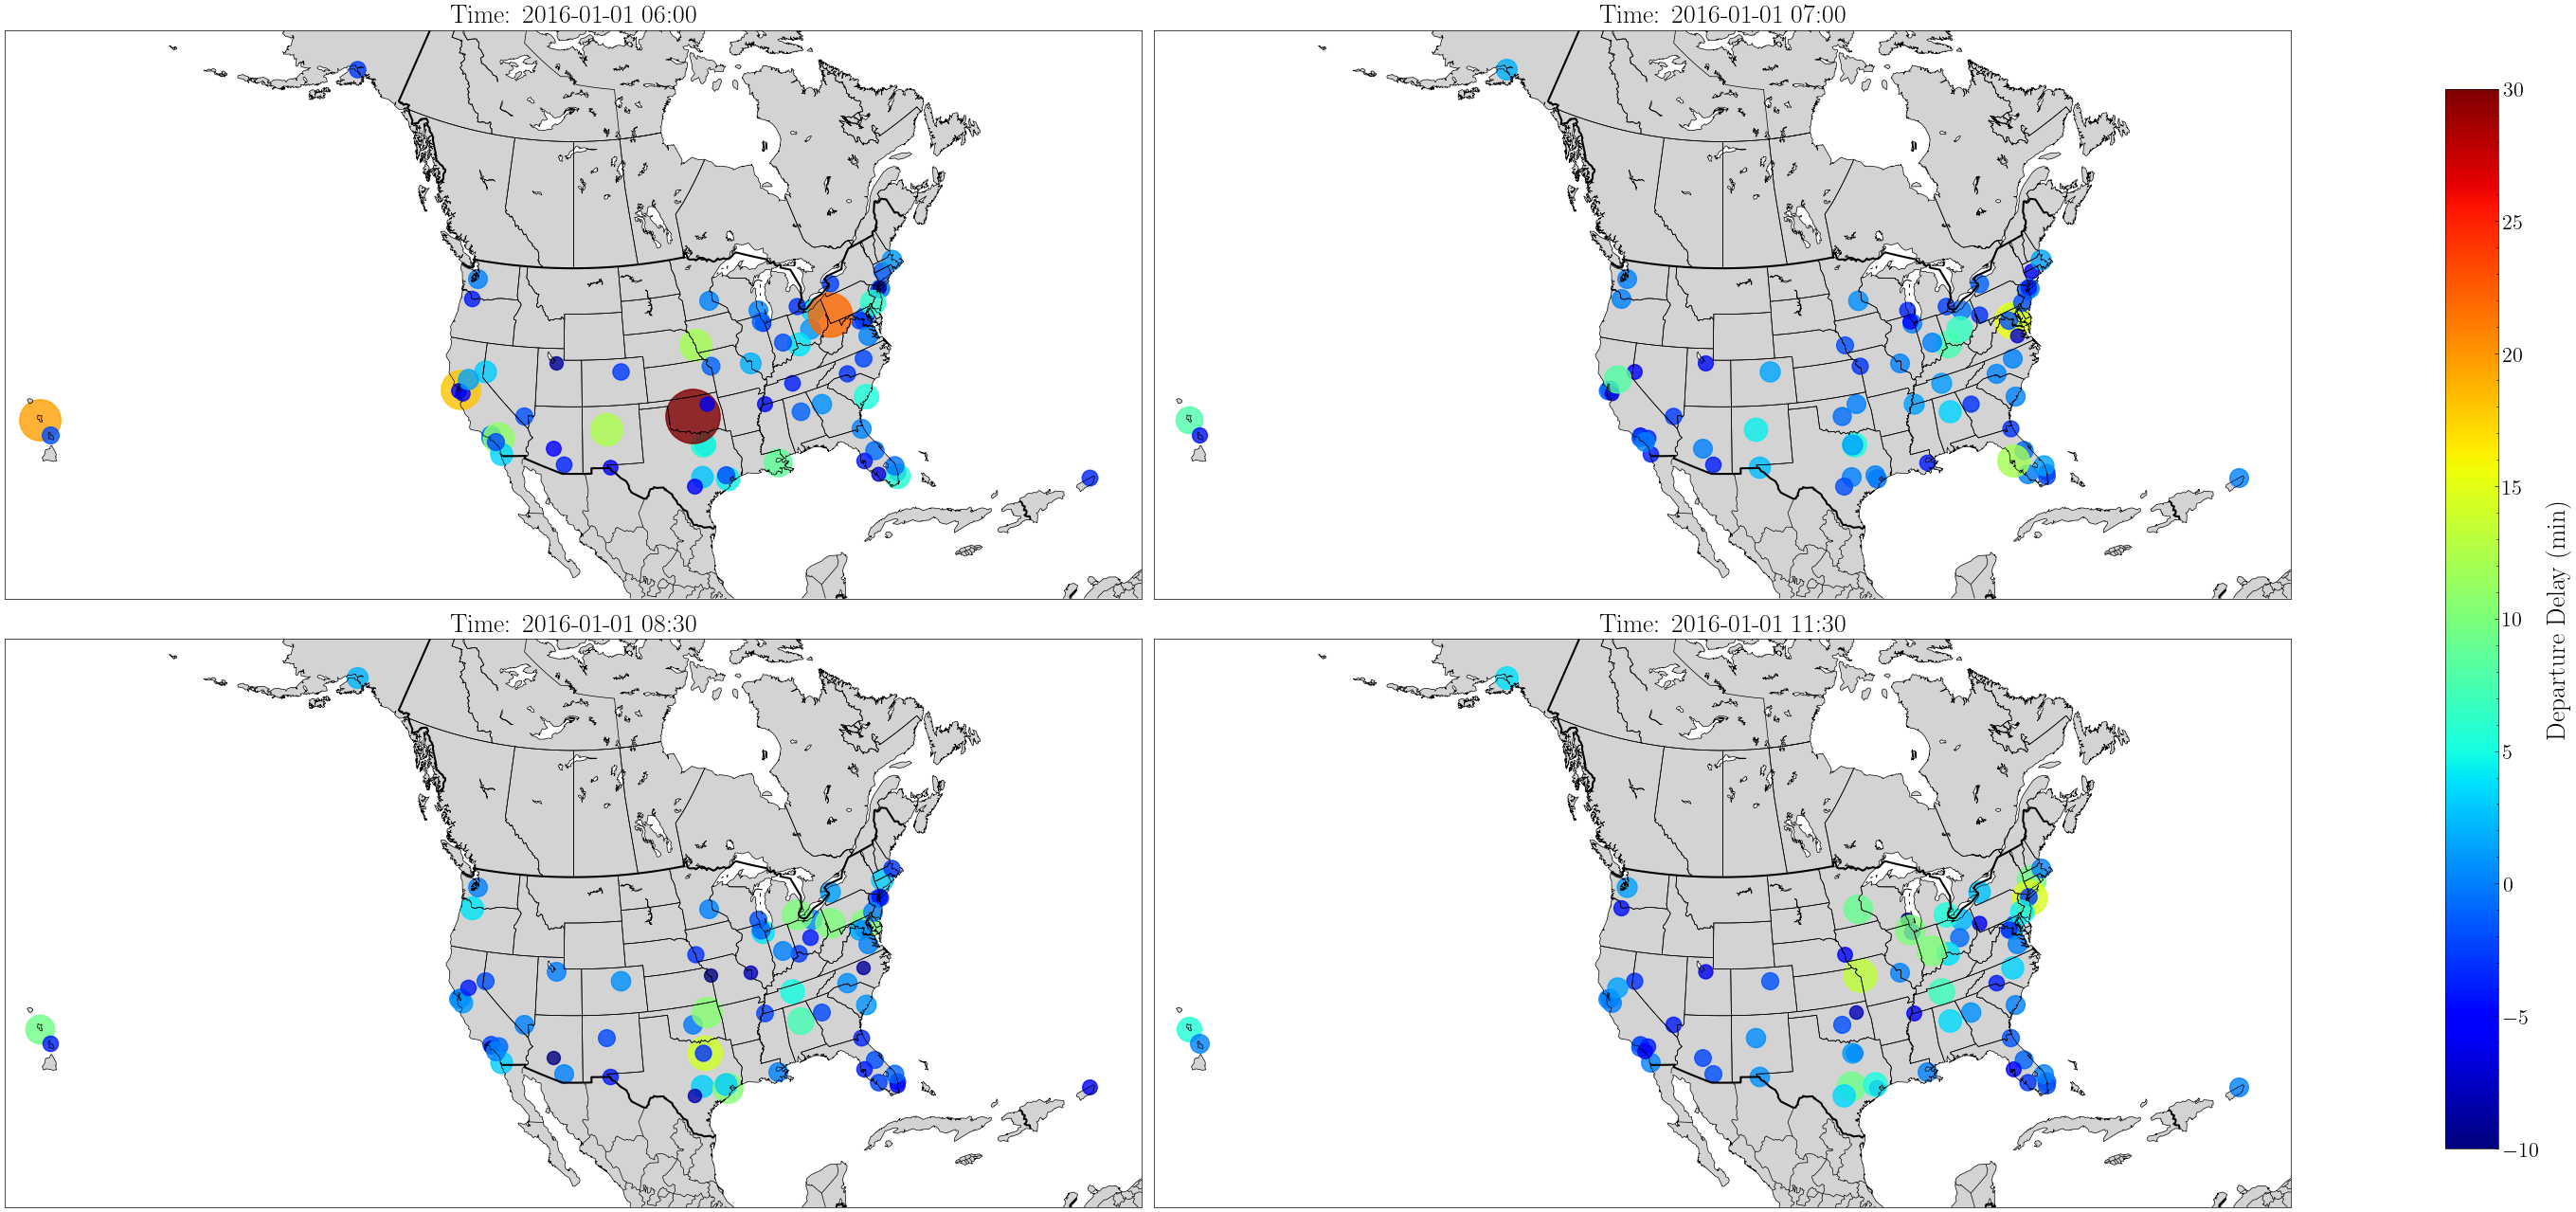

2016-01-01 06:00
2016-01-01 07:00
2016-01-01 08:30
2016-01-01 11:30


In [14]:
# Create a 2x2 grid for the subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(33, 13))

# Plot each map in a subplot
time = [0, 2, 5, 11]
plot_map(axes[0, 0], 0, 'dep')
plot_map(axes[0, 1], 2, 'dep')
plot_map(axes[1, 0], 5, 'dep')
plot_map(axes[1, 1], 11, 'dep')

axes[0, 0].set_title('Time: ' + slot_to_time(0), fontsize=20)
axes[0, 1].set_title('Time: ' + slot_to_time(2), fontsize=20)
axes[1, 0].set_title('Time: ' + slot_to_time(5), fontsize=20)
axes[1, 1].set_title('Time: '+  slot_to_time(11), fontsize=20)

plt.tight_layout()

norm = plt.Normalize(-10, 30)
cmap = plt.get_cmap('jet')
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, label='Departure Delay (min)', shrink=0.9, ax=axes)
cbar.set_label('Departure Delay (min)', fontsize=20)
cbar.ax.tick_params(labelsize=16)

plt.show()
for t in time:
    print(slot_to_time(t))

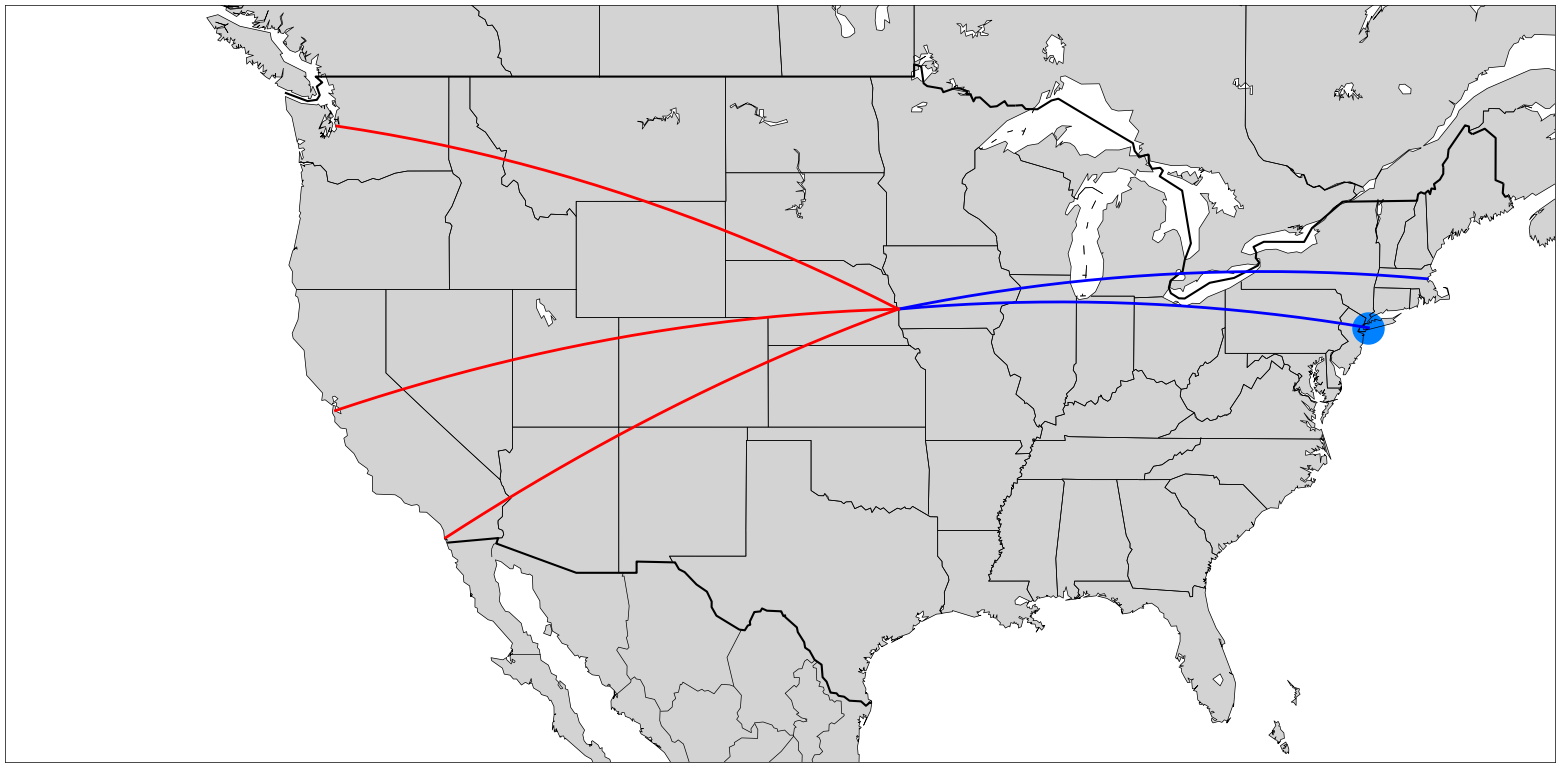

In [15]:
def plot_map(ax, time_slot, delay_type='dep'):
    map = Basemap(llcrnrlon=lon_min+20, llcrnrlat=lat_min+5,
                  urcrnrlon=lon_max+1, urcrnrlat=lat_max-10,
                  resolution='l', projection='merc', ax=ax)
    # map.bluemarble()
    map.drawcoastlines(linewidth=0.5)
    map.drawstates(linewidth=0.5)
    map.drawcountries(linewidth=1.5)
    map.fillcontinents(color='lightgray')
    map.fillcontinents(color='lightgray')
    # map.drawmapboundary(fill_color='lightblue')
    return map


def plot_flight_route(dep, arr, map, linewidth=2, color='b', alpha=1.0):
    dep_lat, dep_lon = get_airport_location(dep)
    arr_lat, arr_lon = get_airport_location(arr)
    map.drawgreatcircle(dep_lon, dep_lat, arr_lon,
                        arr_lat, linewidth=linewidth, color=color, alpha=alpha)
    x1, y1 = map(dep_lon, dep_lat)
    x2, y2 = map(arr_lon, arr_lat)
    # map.scatter(x1, y1, s=100, color='black', marker='o', alpha=1.0)
    # map.scatter(x2, y2, s=100, color='black', marker='o', alpha=1.0)


def plot_points(airport, map, color, size, marker):
    lat, lon = get_airport_location(airport)
    x, y = map(lon, lat)
    map.scatter(x, y, s=size, color=color, marker=marker, alpha=1)


fig, ax = plt.subplots(figsize=(20, 10))

map = plot_map(ax, 5016, 'dep')

# plot airports
norm = plt.Normalize(-10, 30) # 延误时间 -10 到 30 分钟
cmap = plt.get_cmap('jet') # jet: 颜色风格
color = cmap(norm(0)) # todo: 10 分钟延误的颜色
plot_points('JFK', map, color, 500, 'o')

plot_flight_route('JFK', 'OMA', map, linewidth=2, color='b', alpha=1.0)
plot_flight_route('BOS', 'OMA', map, linewidth=2, color='b', alpha=1.0)
plot_flight_route('OMA', 'SFO', map, linewidth=2, color='r', alpha=1.0)
plot_flight_route('OMA', 'SAN', map, linewidth=2, color='r', alpha=1.0)
plot_flight_route('OMA', 'SEA', map, linewidth=2, color='r', alpha=1.0)
plt.show()